In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import subprocess
from io import StringIO
import seaborn as sns
import csv

sys.path.append('../src')

from dataviz.dataviz import plot_timeline, plot_hosts
from dataviz.maps import plot_maps 
from funcs import *

def query_db(query):
    query = " ".join([q.strip() for q in query.split('\n')])
    o = subprocess.check_output("mysql -e \"{}\"".format(query), shell=True)
    df = pd.read_csv(
        StringIO(o.decode()), 
        sep='\t',
        quoting=csv.QUOTE_NONE
    )
    return df

In [4]:
from country_lookup import CountryLookup
countryLocator = CountryLookup(data_dir='../data/country_shapes/')

# Get data 

In [16]:
df = query_db("select * from get_amr2 where refSequence like 'mcr-%%' and bacterial_fragment > 0")

In [17]:
print(df.shape)

# format gene info
df['gene'] = df['refSequence'].apply(lambda x: x.split('.')[0].split('_')[0])
df['gene_variant'] = df['refSequence'].apply(lambda x: x.split('_')[0] if x[5] == '.' else ".".join(x.split('_')[:2]))

# format dates
df['collection_date'] = pd.to_datetime(df['collection_date'], errors='coerce')
df.loc[df['collection_date'].dt.year > 2019, 'collection_date'] = pd.NaT
df.loc[df['collection_date'].dt.year < 2000, 'collection_date'] = pd.NaT
df['collection_year'] = df['collection_date'].dt.year

# format countries
df.replace(['NULL', 'Not available', None, '<NA>', np.nan], pd.NA, inplace=True)

(7739, 16)


In [18]:
count_matrix(df, 
             groupby_col=['run_accession', 'gene'], 
             index_pivot=['run_accession'],
             column_pivot='gene', values='fragmentCountAln').reset_index().merge(df[['run_accession', 'tax_id', 'host', 'country', 'collection_date', 'bacterial_fragment']].drop_duplicates(), on='run_accession', how='left').to_csv('../data/mcr_df.csv', index=None)

In [19]:
mcr_timeline = pd.read_excel('/Users/hanmar/Documents/repos/db_work/data/mcr_timeline.xlsx')

In [20]:
sample_counts = query_db(
    "select host, YEAR(collection_date) as collection_year, country, count(distinct(run_accession)) as runs from metadata inner join run_overview using(run_accession, sample_accession, project_accession) group by host, YEAR(collection_date), country",
    #db_args='../data/db_args.json'
)


# sample_counts['collection_date'] = pd.to_datetime(sample_counts['collection_date'], errors='coerce')
# sample_counts.loc[sample_counts['collection_date'].dt.year > 2019, 'collection_date'] = pd.NaT
# sample_counts.loc[sample_counts['collection_date'].dt.year < 2000, 'collection_date'] = pd.NaT
# sample_counts['collection_year'] = sample_counts['collection_date'].dt.year

# set na values properly
sample_counts.replace(['NULL', 'Not available'], pd.NA, inplace=True)

In [21]:
mcr_tots = count_matrix(df, groupby_col=['run_accession', 'gene'],
    index_pivot = 'run_accession',
    column_pivot = 'gene').merge(
    df.groupby('run_accession').agg(
        {'bacterial_fragment': 'sum'}
    ) / 1e6,
    right_index=True, left_index=True
).sum()

# metadata overview

In [9]:
import plotly.graph_objects as go

In [10]:
df2 = df.copy()
cols = ['country', 'host', 'collection_year']
cols_missing = [f'{col.title()} missing' for col in cols]
for col, mcol in zip(cols, cols_missing): 
    df2[col].replace([
        'root'
    ], np.nan, inplace=True)
    mcol = mcol.replace('_', ' ')
    if df2[col].dtype == np.object:
        df2[col].fillna(mcol, inplace=True)
    elif df2[col].dtype == np.float:
        df2[col].fillna(-1, inplace=True)
        df2[col] = df2[col].astype('int').astype('object')
        df2[col].replace(-1, mcol, inplace=True)
    
n_samples = {
    col: df2.groupby([col])['run_accession'].nunique() for col in cols
}                            

In [11]:
sample_count_nodes = []
for col, mcol in zip(cols, cols_missing):
    mcol = mcol.replace('_',' ')
    
    sts = sample_counts[[col, 'runs']].copy()
    if sts[col].dtype == np.object:
        sts[col].fillna(mcol, inplace=True)
    elif sts[col].dtype == np.float:
        sts[col].fillna(-1, inplace=True)
        sts[col] = sts[col].astype('int').astype('object')
        sts[col].replace([-1, '-1'], mcol, inplace=True)
   
    sample_count_nodes.append(
        sts.groupby(col).agg({'runs': 'sum'})
    )
    
sample_count_nodes = pd.concat(sample_count_nodes)

In [12]:
year_country = pd.DataFrame(df2.groupby(['country', 'collection_year'])['run_accession'].nunique()).reset_index()
#year_country['collection_year'] = year_country['collection_year'].astype('int')
year_country.rename(columns={'collection_year': 'target', 'country': 'source', 'run_accession': 'value'}, inplace=True)
country_host = pd.DataFrame(df2.groupby(['collection_year', 'host'])['run_accession'].nunique()).reset_index()
#country_host['collection_year'] = country_host['collection_year'].astype('int')
country_host.rename(columns={'collection_year': 'source', 'host': 'target', 'run_accession': 'value'}, inplace=True)


counts = pd.concat([year_country, country_host])

counts_nodes = pd.DataFrame({'label': pd.concat([counts['source'], counts['target']]).unique()})
counts_nodes.index.name = 'ID'
counts_nodes.reset_index(inplace=True)
counts_nodes.replace(-1, 'Missing', inplace=True)

l2id={}
for _, row in counts_nodes.iterrows():
    l2id[row['label']] = row['ID']

counts['source_id'] = counts['source'].map(l2id)
counts['target_id'] = counts['target'].map(l2id)
counts.sort_values(by='value', inplace=True)


def label_count(label):
    for kv in n_samples.values():
        if label in kv.keys():
            return kv[label]

counts_nodes['n'] = counts_nodes['label'].apply(label_count)

counts_nodes = counts_nodes.merge(
    sample_count_nodes,
    left_on='label', right_index=True, how='left'
)

counts_nodes['extended_label'] = counts_nodes.apply(
    lambda x: f"{x['label']} ({x['n']}/{x['runs']:.0f} ({x['n']/x['runs']*100:.2f}%))", 
    axis=1)

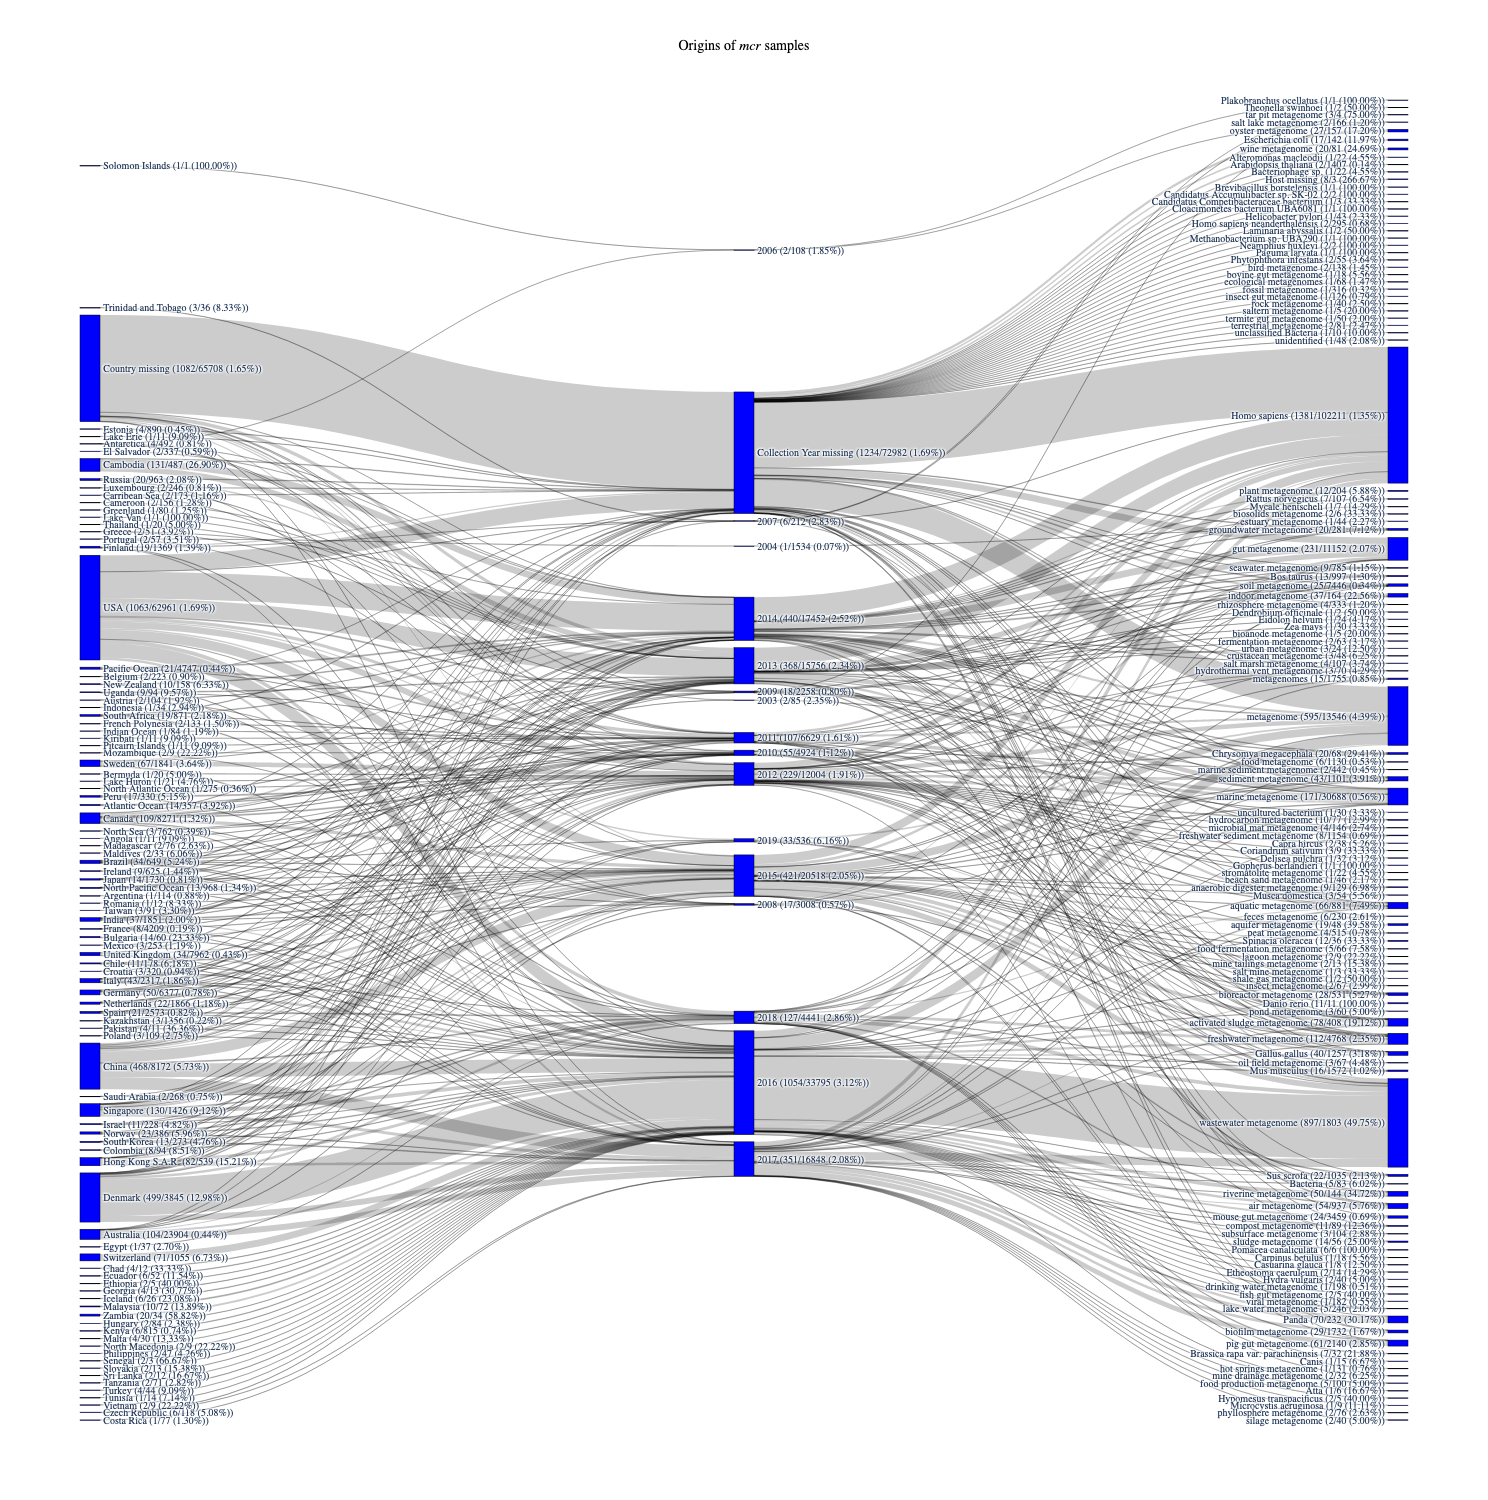

In [13]:

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = counts_nodes['extended_label'],
      color = "blue"
    ),
    link = dict(
      source = counts.source_id, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = counts.target_id,
      value = counts.value
  ))])

fig.update_layout(
    title={
        'text': "Origins of <i>mcr</i> samples",
        'xanchor': 'center',
        'x': 0.5,
        'font_color': 'black'
    },
    font_size=10,
    font_family='DejaVu Sans',
    height=1500,
    width=850
)
fig.show()

In [66]:
df.query('gene=="mcr-6"')

run_accession         db db_version    run_date kma_version      country  \
0        DRR014155  ResFinder   20200125  2020-11-10       1.3.0         None   
1        DRR014187  ResFinder   20200125  2020-11-10       1.3.0         None   
2        DRR046817  ResFinder   20200125  2020-11-10       1.3.0        Japan   
3        DRR046817  ResFinder   20200125  2020-11-10       1.3.0        Japan   
4        DRR046817  ResFinder   20200125  2020-11-10       1.3.0        Japan   
...            ...        ...        ...         ...         ...          ...   
7734    SRR9879871  ResFinder   20200125  2021-02-22       1.3.9         <NA>   
7735    SRR9879887  ResFinder   20200125  2021-02-22       1.3.9         <NA>   
7736    SRR9879889  ResFinder   20200125  2021-02-22       1.3.9         <NA>   
7737    SRR9967726  ResFinder   20200125  2021-02-12       1.3.9  Netherlands   
7738     SRR999554  ResFinder   20200125  2020-02-04      1.2.21      Denmark   

                     location  country_latitude  country_longitude    tax_id  \
0                        None               NaN                NaN    9606.0   
1                        None               NaN                NaN  410657.0   
2        35.6693 N 139.4257 E           35.6833          139.75000  942017.0   
3        35.6693 N 139.4257 E           35.6833          139.75000  942017.0   
4        35.6693 N 139.4257 E           35.6833          139.75000  942017.0   
...                       ...               ...                ...       ...   
7734                     <NA>               NaN                NaN    9606.0   
7735                     <NA>               NaN                NaN    9606.0   
7736                     <NA>               NaN                NaN    9606.0   
7737       52.1583 N 4.4931 E           52.3500            4.91667    9606.0   
7738  55.398487 N 10.420596 E           55.6667           12.58330  942017.0   

                             host collection_date                refSequence  \
0                    Homo sapiens             NaT  mcr-9_1_NZ_NAAN01000063.1   
1          ecological metagenomes             NaT         mcr-5.1_1_KY807921   
2     activated sludge metagenome      2014-01-01        mcr-3.24_1_NG060580   
3     activated sludge metagenome      2014-01-01         mcr-4.1_1_MF543359   
4     activated sludge metagenome      2014-01-01         mcr-5.1_1_KY807921   
...                           ...             ...                        ...   
7734                 Homo sapiens             NaT         mcr-4.3_1_MG026621   
7735                 Homo sapiens             NaT         mcr-4.3_1_MG026621   
7736                 Homo sapiens             NaT         mcr-4.4_1_MG822665   
7737                 Homo sapiens      2016-03-14         mcr-2.1_1_LT598652   
7738  activated sludge metagenome      2011-11-01         mcr-5.1_1_KY807921   

      refSequence_length  fragmentCountAln  bacterial_fragment   gene  \
0                   1620               2.0               18512  mcr-9   
1                   1644             122.0               38310  mcr-5   
2                   1626               7.0              130311  mcr-3   
3                   1626               3.0              130311  mcr-4   
4                   1644               4.0              130311  mcr-5   
...                  ...               ...                 ...    ...   
7734                1626               2.0                7418  mcr-4   
7735                1626              24.0                 718  mcr-4   
7736                1626               2.0                8624  mcr-4   
7737                1617               1.0              650793  mcr-2   
7738                1644              34.0               42543  mcr-5   

     gene_variant  collection_year  
0         mcr-9.1              NaN  
1         mcr-5.1              NaN  
2        mcr-3.24           2014.0  
3         mcr-4.1           2014.0  
4         mcr-5.1           2014.0  
...        

# Timeline 

In [58]:
cm_year = count_matrix(
    df = df.query("collection_year >= 2000"),
    groupby_col=['collection_year', 'gene'],
    index_pivot = 'collection_year',
    column_pivot = 'gene'
).merge(
    df.groupby('collection_year').agg(
        {'bacterial_fragment': 'sum'}
    ) / 1e6,
    right_index=True, left_index=True
)

cm_year_closed = cm_year.drop(columns='bacterial_fragment').apply(closure, axis=1)
cm_year_alr = cm_year.apply(alr, axis=1)#.replace([np.inf, -np.inf])


/Users/hanmar/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
timesamples = count_samples(df.query("collection_year >= 2000"), sample_counts, val_col='runs')
timesamples['year'] = timesamples.index.astype('int')
timesamples.sort_values(by='year', inplace=True)

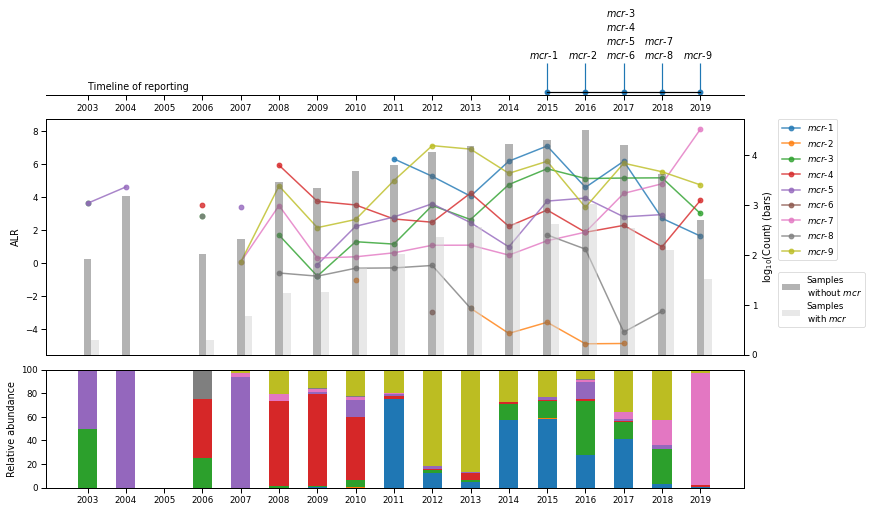

In [16]:
sns.set_context('paper')
time_plot = plot_timeline(
    cm = cm_year_alr,
    cm_closed = cm_year_closed,
    gene_timeline = mcr_timeline,
    timesamples = timesamples,
    samples_ys = ['Samples\nwithout $mcr$', 'Samples\nwith $mcr$']
)
#time_plot.savefig('../output/mcr_time_PAPER.pdf')
time_plot

In [17]:
sns.set_context('talk')
time_plot = plot_timeline(
    cm = cm_year_alr,
    cm_closed = cm_year_closed,
    gene_timeline = mcr_timeline,
    timesamples = timesamples,
    samples_ys = ['Samples\nwithout $mcr$', 'Samples\nwith $mcr$'],
    figsize=(18, 10)
)
time_plot.savefig('../output/mcr_time_TALK.pdf')

# Maps

In [35]:
cm_country = count_matrix(
    df = df.query("collection_year >= 2000").replace(['NULL', 'not applicable', 'not available'], pd.NA),
    groupby_col=['country', 'gene'],
    index_pivot = 'country',
    column_pivot = 'gene'
).merge(
    df.groupby('country').agg(
        {'bacterial_fragment': 'sum'}
    ) / 1e6,
    right_index=True, left_index=True
)

cm_country.rename(index={
    'USA':'United States of America',
    'North Macedonia': 'Macedonia',
    'Tanzania': 'United Republic of Tanzania',
    'Czech Republic': 'Czechia'
}, inplace=True)


cm_country_closed = cm_country.drop(columns='bacterial_fragment').apply(closure, axis=1)
cm_country_alr = cm_country.apply(alr, axis=1)#.replace([np.inf, -np.inf])

cm_country_alr_total = pd.DataFrame(cm_country.apply(tot_alr, axis=1))
cm_country_alr_total.rename(columns={0: 'Total ALR'}, inplace=True)

/Users/hanmar/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [36]:
cm_country_alr_total.reset_index(inplace=True)
cm_country_alr_total[['geo', 'geotype']] = cm_country_alr_total['country'].apply(
    lambda x: countryLocator.name2geo(x) if not isinstance(x, float) else pd.NA
).apply(pd.Series)
cm_country_alr_total.set_index('country', inplace=True)

cm_country_alr.reset_index(inplace=True)
cm_country_alr[['geo', 'geotype']] = cm_country_alr['country'].apply(
    lambda x: countryLocator.name2geo(x) if not isinstance(x, float) else pd.NA
).apply(pd.Series)
cm_country_alr.set_index('country', inplace=True)

TypeError: unsupported operand type(s) for ** or pow(): 'int' and 'dict'

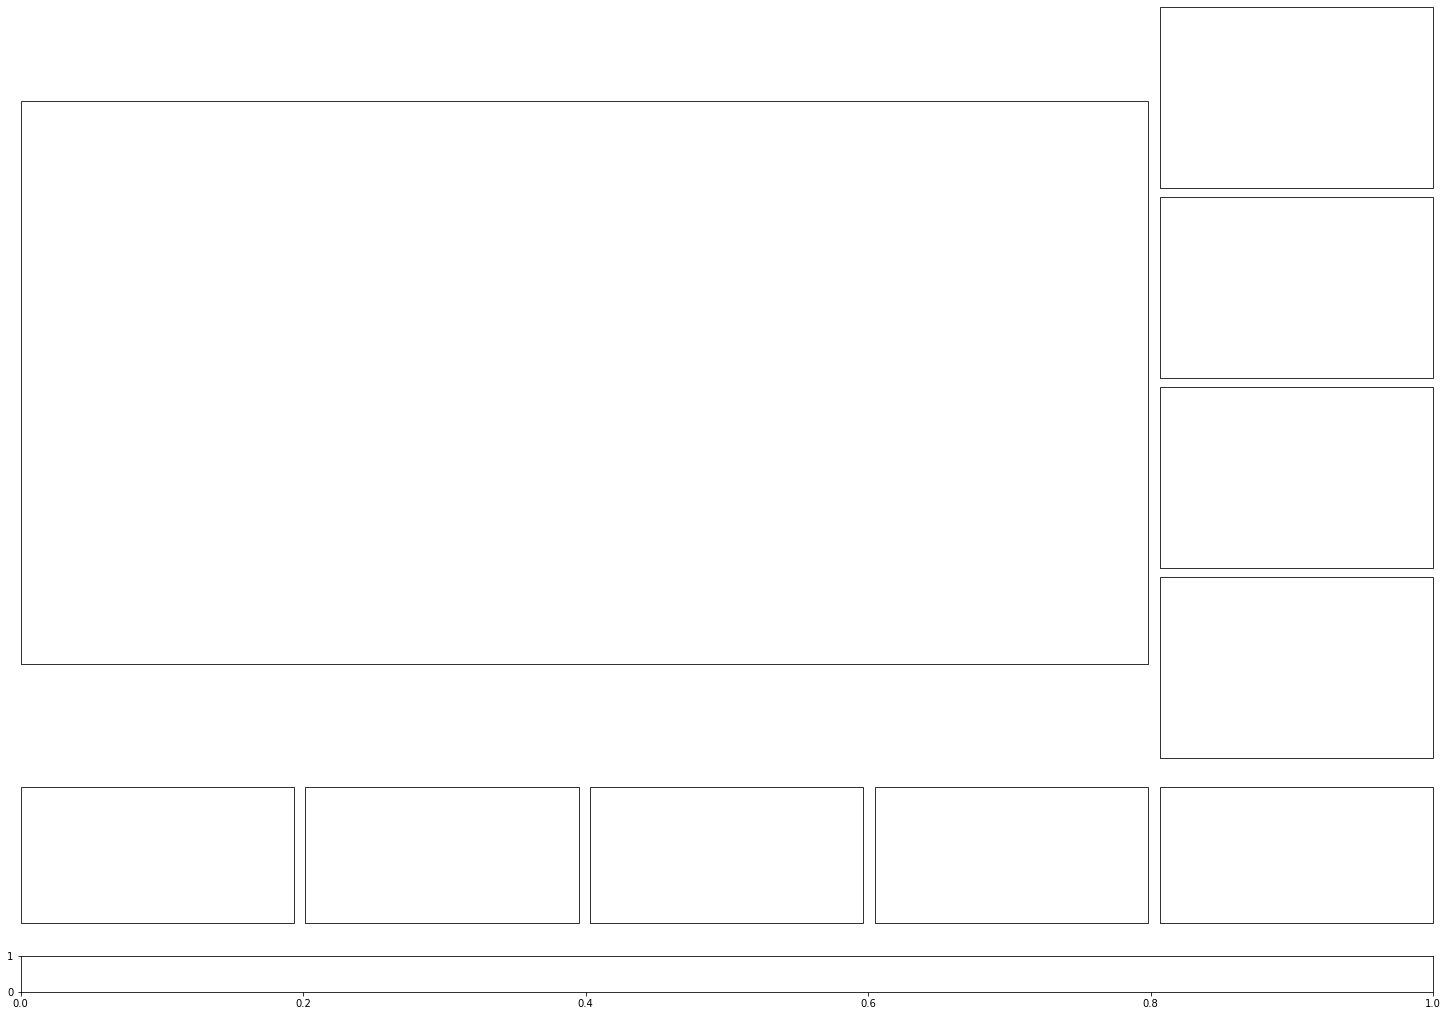

In [37]:
maps = plot_maps(
    cm = cm_country_alr.select_dtypes('float'),
    cm_tot = cm_country_alr_total.select_dtypes('float'),
    ncols=5,nrows=6,
    left_on='country'
)

maps.savefig('../output/mcr_maps_PAPER.pdf')
maps.savefig('../output/mcr_maps_PAPER.png')
maps

In [ ]:
countries_info = pd.read_json('https://raw.githubusercontent.com/mledoze/countries/master/countries.json')
countries_info = pd.concat([countries_info, countries_info['name'].apply(pd.Series)], axis=1)

### individual plots

In [71]:
vmax = max(cm_country_alr.max().max().item(), cm_country_alr_total['Total ALR'].max().max().item())
vmin = max(cm_country_alr.min().min().item(), cm_country_alr_total['Total ALR'].min().min().item())

<ipython-input-71-b3f591e29892>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vmax = max(cm_country_alr.max().max().item(), cm_country_alr_total['Total ALR'].max().max().item())
<ipython-input-71-b3f591e29892>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vmin = max(cm_country_alr.min().min().item(), cm_country_alr_total['Total ALR'].min().min().item())


In [25]:
genes = sorted(cm_country_alr.columns.tolist())

AttributeError: 'float' object has no attribute '_geom'

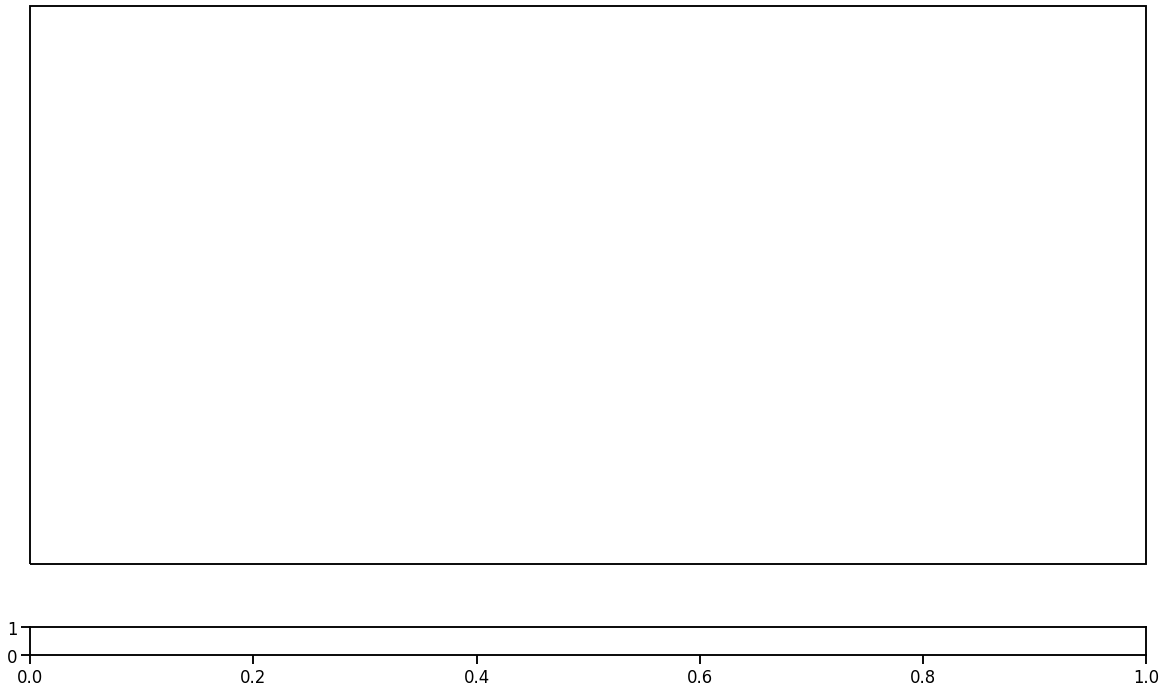

In [27]:
import cartopy.crs as ccrs
ncols = 1
nrows = 2
for gene in genes:
    fig = plt.figure(figsize=(20,12))
    gs = fig.add_gridspec(ncols=ncols, nrows=nrows, height_ratios=np.repeat(1, nrows-1).tolist() + [.05])
    ax_main = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
    #ax_main.set_aspect('auto') 
    ax_bar = fig.add_subplot(gs[1])
    
    gene_map = countryLocator.cartopy_map(
        df = cm_country_alr,
        valcol = gene,
        geocol = 'geo',
        ax_map=ax_main,
        ax_cbar = ax_bar,
        vmin=vmin,
        vmax=vmax,
        cbar_label='ALR'
    )
    
    fig.subplots_adjust(hspace = 0)
    ax_main.set_title('${}$-{}'.format(*gene.split('-')))
    
    fig.savefig(f'../output/individual_maps/{gene}_map.pdf')
    plt.close(fig)

# Host

In [60]:
cm_host = count_matrix(
    df = df.query("collection_year >= 2000").replace(['NULL', 'not applicable', 'not available'], pd.NA),
    groupby_col=['host', 'gene'],
    index_pivot = 'host',
    column_pivot = 'gene'
).merge(
    df.groupby('host').agg(
        {'bacterial_fragment': 'sum'}
    ) / 1e6,
    right_index=True, left_index=True
)


cm_host_closed = cm_host.drop(columns='bacterial_fragment').apply(closure, axis=1)
cm_host_alr = cm_host.apply(alr, axis=1)#.replace([np.inf, -np.inf])

cm_host_alr_total = pd.DataFrame(cm_host.apply(tot_alr, axis=1))
cm_host_alr_total.rename(columns={0: 'Total ALR'}, inplace=True)

In [29]:
host_samples = count_samples(df.query("collection_year >= 2000"), sample_counts, val_col='runs', col='host')
host_samples.sort_values(by='host', inplace=True)

/Users/hanmar/Documents/repos/db_work/env/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

divide by zero encountered in log10



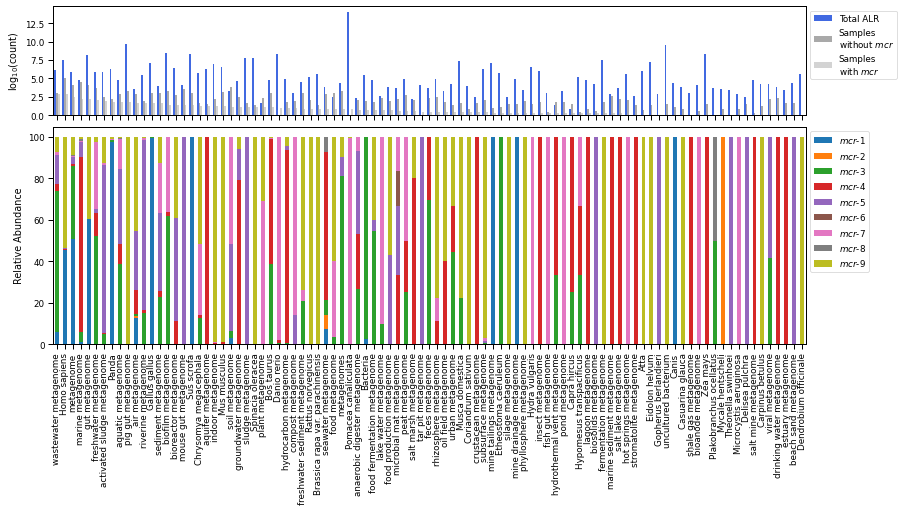

In [30]:
sns.set_context('paper')
host_plot = plot_hosts(
    cm_tot = cm_host_alr_total, 
    cm_closed = cm_host_closed, 
    host_counts = host_samples,
    samples_ys = ['Total ALR', 'Samples\nwithout $mcr$', 'Samples\nwith $mcr$'],
    sample_colors={
        'Total ALR': 'royalblue',
        'Samples\nwithout $mcr$': 'darkgray', 
        'Samples\nwith $mcr$': 'lightgray'
    },
    sort_by='Samples\nwith $mcr$'
)
host_plot.savefig('../output/mcr_hosts_ALL_PAPER.pdf')
host_plot.savefig('../output/mcr_hosts_ALL_PAPER.png')
host_plot

In [31]:
sns.set_context('talk')
host_plot = plot_hosts(
    cm_tot = cm_host_alr_total, 
    cm_closed = cm_host_closed, 
    host_counts = host_samples,
    samples_ys = ['Total ALR', 'Samples\nwithout $mcr$', 'Samples\nwith $mcr$'],
    sample_colors={
        'Total ALR': 'royalblue',
        'Samples\nwithout $mcr$': 'darkgray', 
        'Samples\nwith $mcr$': 'lightgray'
    },
    sort_by='Samples\nwith $mcr$',
    figsize=(20, 14)
)
host_plot.savefig('../output/mcr_hosts_ALL_TALK.pdf')

In [32]:
cm_host_alr2 = cm_host_alr.merge(
    cm_host_alr_total, right_index=True, left_index=True
).replace([np.inf, -np.inf], np.nan).merge(
    sample_counts.groupby('host').agg({'runs': 'sum'}).rename(columns={'runs': 'n_runs'}),
    right_index=True, left_index=True
).merge(
    df.groupby('host')['run_accession'].nunique().apply(pd.Series).rename(columns={0: 'n_mcr'}),
    right_index=True, left_index=True
)

cm_host_alr2['pct_mcr'] = ((cm_host_alr2['n_mcr'] / cm_host_alr2['n_runs'])*100).round(2)


## subset host for those that are significant

In [36]:
host_aldex2 = pd.read_csv('../data/host_aldex2.csv')
selected_hosts = host_aldex2.loc[host_aldex2['we.eBH'] < 0.05].apply(
    lambda x: x['conditionA'] if x['conditionA'] != 'Other' else x['conditionB'],
    axis=1
).unique()

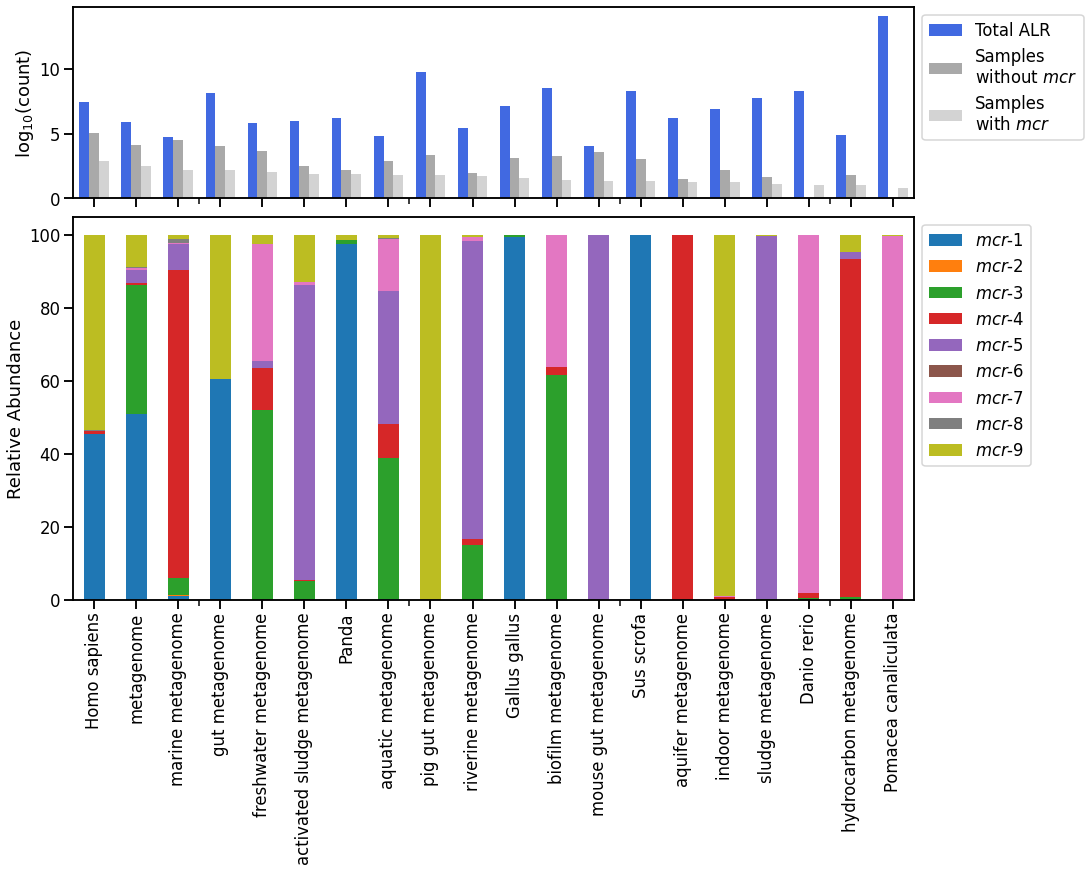

In [37]:
sns.set_context('paper')
host_plot = plot_hosts(
    cm_tot = cm_host_alr_total.loc[selected_hosts], 
    cm_closed = cm_host_closed.loc[selected_hosts], 
    host_counts = host_samples.loc[selected_hosts],
    samples_ys = ['Total ALR', 'Samples\nwithout $mcr$', 'Samples\nwith $mcr$'],
    sample_colors={
        'Total ALR': 'royalblue',
        'Samples\nwithout $mcr$': 'darkgray', 
        'Samples\nwith $mcr$': 'lightgray'
    },
    sort_by='Samples\nwith $mcr$',
)
host_plot.savefig('../output/mcr_hosts_SELECTED_PAPER.pdf')
host_plot.savefig('../output/mcr_hosts_SELECTED_PAPER.png')

sns.set_context('talk')
host_plot = plot_hosts(
    cm_tot = cm_host_alr_total.loc[selected_hosts], 
    cm_closed = cm_host_closed.loc[selected_hosts], 
    host_counts = host_samples.loc[selected_hosts],
    samples_ys = ['Total ALR', 'Samples\nwithout $mcr$', 'Samples\nwith $mcr$'],
    sample_colors={
        'Total ALR': 'royalblue',
        'Samples\nwithout $mcr$': 'darkgray', 
        'Samples\nwith $mcr$': 'lightgray'
    },
    sort_by='Samples\nwith $mcr$',
    figsize=(15, 12)
)
host_plot.savefig('../output/mcr_hosts_SELECTED_TALK.pdf')
host_plot


# export

In [4]:
metacols = ['run_accession', 'host', 'collection_date', 'country', 'bacterial_fragment']
e = count_matrix(
    df,
    groupby_col=metacols + ['gene'],
    index_pivot = metacols,
    column_pivot = ['gene']
)
e['tot_mcr'] = e.sum(1)

e.to_csv('../data/mcr_pivot_runs.csv')

In [23]:
# for pca
import pycoda
parts = [f'mcr-{i+1}' for i in range(0, 9)]
e_zr = e[parts].coda.zero_replacement()

e_clr = e_zr.coda.clr()

e_clr.index = pd.MultiIndex.from_tuples(e_clr.index, names=e.index.names)
e_clr.to_csv('../data/mcr_pivot_runs_clr_mcr1-9.csv')

In [24]:
def pca(data, parts, metadf=None, left_on=None, left_index=False):
    
    # replace zeroes
    df = data[parts].coda.zero_replacement()
    
    # close
    df = df.coda.closure(100)
      
    # clr transform
    df_clr = df.coda.center().coda.clr()
    
    # run SVD
    scores, eig_val, loadings = np.linalg.svd(df_clr)
    n_eig = len(eig_val)
    
    # explained variance by each pc
    explained_variance = ( eig_val ** 2 / np.sum(eig_val ** 2)) * 100
    explained_variance = pd.DataFrame(
        explained_variance,
        index=[f'PC{i+1}' for i in range(n_eig)],
        columns=['Explained Variance']
    )
    #explained_variance.columns.name = 'Variance'
    explained_variance.index.name = 'Principal Component'

    # make scores df
    scores = pd.DataFrame(
        scores.T,
        columns=df_clr.index
    )

    # loadings df
    # take inner product of eig_val * identity matrix of number of eigenvalues
    loadings = pd.DataFrame(
        np.inner(
            eig_val * np.identity(n_eig),
            loadings.T[0:n_eig, 0:n_eig]
        ),
        columns=df_clr.columns[0:n_eig],
        index=[f'PC{i+1}' for i in range(n_eig)]
    )

    scales = [np.max(np.abs(loadings.values)),
                  [np.max(np.abs(scores.loc[idx].values)) for idx in range(1, n_eig+1)]]

    scores = scores[0:n_eig]

    scores = (scales[0] * (scores.T / scales[1])).T
    
    if metadf is not None:
        scores_ext = scores.T.merge(metadf, right_index=True, left_index=left_index, left_on=left_on)
        return explained_variance, scores, loadings, scales, scores_ext
    
    return explained_variance, scores, loadings, scales
    
explained_variance, scores, loadings, scales = pca(data=e, parts=parts)

(9, 3135)
2
26.877203770343787
9


In [25]:
scores = scores.T
scores.index = pd.MultiIndex.from_tuples(scores.index, names=e.index.names)
scores.to_csv('../data/mcr_pca_scores_mcr1-9.csv')
loadings.to_csv('../data/mcr_pca_loadings_mcr1-9.csv')
explained_variance.to_csv('../data/mcr_pca_expvar_mcr1-9.csv')

# Comparing metagenomic distributions to single isolates

## Import data from NCBI Pathogen browser

In [ ]:
from bs4 import BeautifulSoup
import requests
from urllib.request import HTTPError
url = 'https://ftp.ncbi.nlm.nih.gov/pathogen/Results'

page = requests.get(url).text
soup = BeautifulSoup(page, 'html.parser')

organisms = [url + '/'  + node.get('href') for node in soup.find_all('a') if not node.get('href').endswith('/pathogen/')]
organism_results = []
for org_link in organisms:
    org_page = requests.get(org_link).text
    org_soup = BeautifulSoup(org_page, 'html.parser')
    
    newest, newest_date = None, datetime.strptime('00010101 01:01', '%Y%m%d %H:%M') 
    for tag in org_soup.find_all('a'):
        if tag.get('href').startswith('PDG'):
            link_date = datetime.strptime(tag.next_sibling.replace('-', '').strip(), '%Y%m%d %H:%M')
            if link_date > newest_date:
                newest_date = link_date
                newest = org_link + '/' + tag.get('href')

    organism_results.append(newest)



genes = ['mcr-' + str(i) for i in range(1, 10)]
allOrgData = []
for org_result in organism_results:
    try:
        sdf = pd.read_csv(org_result + 'AMR/' + org_result.split('/')[-2] + '.amr.metadata.tsv', sep='\t')
    except HTTPError: 
        sdf = pd.read_csv(org_result + '/Metadata/' + org_result.split('/')[-2] + '.metadata.tsv', sep='\t') 
    sdf['AMR_genotypes'].fillna('', inplace=True)
    #for gene in genes:
    #    sdf[gene] = sdf.AMR_genotypes.str.contains(gene).fillna(0).astype('int')
    sdf = sdf[['#label','Run', 'collected_by', 'collection_date', 'geo_loc_name', 'host', 'isolation_source', 'lat_lon', 'scientific_name', 'species_taxid', 'taxid', 'AMR_genotypes']]
    allOrgData.append(sdf)

allOrg = pd.concat(allOrgData)

    
genes = [(f'mcr-{i}', f'(mcr-{i}[^0])') for i in range(1,11)]

for gene in genes:
    allOrg[gene[0]] = (~(allOrg.AMR_genotypes.str.extract(gene[1]).isna())).astype('int')    

def taxid2name(x):
    try:
        df = query_db(f'select * from taxa where tax_id={x}')
        tname = df['name'].item()
    except:
        tname = 'NULL'
    return tname

tax2species = {x: taxid2name(x) for x in allOrg.species_taxid.unique()}
allOrg['species'] = allOrg['species_taxid'].map(tax2species)

allOrg.to_csv('../data/single_isolates.csv')

In [7]:
allOrg = pd.read_csv('../data/single_isolates.csv')
allOrg.head()

Unnamed: 0                                             #label  Run  \
0           0  PDT000005252.2|SAMEA3138279|GCA_000069245.1|Ac...  NaN   
1           1  PDT000006299.2|SAMN02469415|GCA_000177715.1|Ac...  NaN   
2           2  PDT000007156.2|SAMN00189092|GCA_000163395.2|Ac...  NaN   
3           3  PDT000007481.2|SAMN02603494|GCA_000188215.1|Ac...  NaN   
4           4  PDT000008611.2|SAMN02471594|GCA_000189655.2|Ac...  NaN   

  collected_by collection_date    geo_loc_name          host  \
0          NaN             NaN             NaN           NaN   
1          NaN            2003             USA  Homo sapiens   
2          NaN         missing  not determined  Homo sapiens   
3          NaN             NaN             NaN           NaN   
4          NaN             NaN             NaN           NaN   

                                    isolation_source         lat_lon  \
0                                                NaN             NaN   
1  patient at Walter Reed Army Medical Center wit...             NaN   
2                                               skin  not determined   
3                                                NaN             NaN   
4                                                NaN             NaN   

                   scientific_name  ...  mcr-2  mcr-3 mcr-4  mcr-5  mcr-6  \
0      Acinetobacter baumannii AYE  ...      0      0     0      0      0   
1    Acinetobacter baumannii AB058  ...      0      0     0      0      0   
2  Acinetobacter baumannii 6014059  ...      0      0     0      0      0   
3   Acinetobacter baumannii 1656-2  ...      0      0     0      0      0   
4    Acinetobacter baumannii AB210  ...      0      0     0      0      0   

   mcr-7  mcr-8  mcr-9  mcr-10  ('mcr-1', '(mcr-1[^0])')  
0      0      0      0       0                         0  
1      0      0      0       0                         0  
2      0      0      0       0                         0  
3      0      0      0       0                         0  
4      0      0      0       0                         0  

[5 rows x 24 columns]

In [9]:
genes = [f'mcr-{i}' for i in range(1, 10)]

## Compare distributions

### Time

In [ ]:
from datetime import datetime
def convert_to_year(date, unk=None):    
    date2year = {0: '%Y', 1: '%Y-%M', 2: '%Y-%M-%d'}

    if unk is None: unk = pd.NaT
    
    if isinstance(date, str):
        if date.lower() == 'missing' or '/' in date:
            return unk
        else:
            try:
                y = datetime.strptime(date, date2year[date.count('-')]).year
            except ValueError:
                y = unk
            return y
    
    elif np.isnan(date):
        return unk

allOrg['year'] = allOrg.collection_date.apply(convert_to_year)

In [12]:
genes = [f'mcr-{i}' for i in range(1, 10)]

# find years with mcr genes in both isolates and metagenomes
sampling_years = sorted(list(set(allOrg.loc[((allOrg[genes] > 0).any(1)), 'year'].dropna().unique().tolist() + df.collection_year.dropna().unique().astype('int').tolist())))

sample_counts.collection_year.replace([2021, 2020], np.nan, inplace=True)
df.collection_year.replace([2021, 2020], np.nan, inplace=True)
# count occurence of samples available and those containing mcr genes
YearCounts = pd.concat(
    [
        sample_counts.loc[sample_counts['collection_year'].isin(sampling_years), ].groupby('collection_year').agg({'runs': 'sum'}).rename(columns={'runs': 'metagenome_samples'}),
        df.loc[df['collection_year'].isin(sampling_years),].drop_duplicates('run_accession').groupby('collection_year').agg({'run_accession': 'count'}).rename(columns={'run_accession': 'metagenome_pos'}),
        allOrg.loc[allOrg['year'].isin(sampling_years), ].groupby('year').agg({'#label': 'count'}).rename(columns={'#label': 'isolate_samples'}),
        allOrg.loc[
            (allOrg['year'].isin(sampling_years)) &
            ((allOrg[genes] > 0).any(1)) ].groupby('year').agg({'#label': 'count'}).rename(columns={'#label':'isolate_pos'})
    ],
    axis = 1,
    #keys = ['metagenome', 'metagenome', 'single_isolate', 'single_isolate']
)

YearCounts.index = YearCounts.index.astype('int')

# get frequency of mcr variants in positive samples
metagenome_year_closed = cm_year_closed.copy()
single_year_closed =  allOrg.loc[ (allOrg['year'].isin(sampling_years)), ].groupby('year').agg({g: 'sum' for g in genes}).coda.closure(100)
for y in sampling_years:
    if y not in metagenome_year_closed.index:
        metagenome_year_closed.loc[y] = 0
        
    if y not in single_year_closed.index:
        single_year_closed.loc[y] = 0

YearClosed = pd.concat([ single_year_closed, cm_year_closed], keys=['single_isolate', 'metagenome'], axis=1).fillna(0)
YearClosed.index = YearClosed.index.astype('int')

KeyError: 'year'

In [141]:
fig, axes = plt.subplots(1, 5, figsize=(20,10), gridspec_kw={'width_ratios': [.15, 1, .035, 1, .15]}, sharey=True)

ax_meta_tot, ax_meta, ax_hidden, ax_single, ax_single_tot = axes

ax_hidden.axis('off')

# SAMPLE COUNTS
YearCounts['metagenome_samples'].apply(np.log10).plot.barh(color='grey', ax=ax_meta_tot, label='Samples available')
YearCounts['metagenome_pos'].apply(np.log10).plot.barh(color='lightgrey', ax=ax_meta_tot, label='Samples with mcr')

YearCounts['isolate_samples'].apply(np.log10).plot.barh(color='grey', ax=ax_single_tot, label='Samples available')
YearCounts['isolate_pos'].apply(np.log10).plot.barh(color='lightgrey', ax=ax_single_tot, label='Samples with mcr')

# RELATIVE ABUNDANCES / RELATIVE COUNTS
YearClosed.loc[:,'single_isolate'].plot.barh(stacked=True, ax=ax_single)
YearClosed.loc[:,'metagenome'].plot.barh(stacked=True, ax=ax_meta)

# format axis
totmin = -.5
totmax = max(*ax_meta_tot.get_xlim(), *ax_single_tot.get_xlim())
ax_meta_tot.set_xlim(totmin, totmax)
ax_single_tot.set_xlim(totmin, totmax)
ax_meta_tot.invert_xaxis()

# FORMAT LABELS
ax_meta_tot.set_xlabel('$\log_{10}$ count')
ax_single_tot.set_xlabel('$\log_{10}$ count')

ax_meta.set_xlabel('Relative abundance')
ax_single.set_xlabel('Relative count')

ax_meta.set_title('Metagenomes')
ax_single.set_title('Single isolates')

# FORMAT LEGENDS
ax_meta.legend(loc='lower right')
ax_single.get_legend().remove() # no need for duplicate labels
ax_meta_tot.legend(loc='lower left', bbox_to_anchor=(1.65,0))

ax_meta_tot.set_zorder(1)

# FORMAT TICK PLACEMENT AND LABELS
ax_meta.yaxis.tick_right()
ax_meta_tot.yaxis.tick_right()

ax_meta_tot.tick_params(labelright=False)  
ax_meta.tick_params(labelright=True)

# adjust space
plt.subplots_adjust(wspace=.05)

fig.savefig('../output/comparison_single_time.pdf')
fig.savefig('../output/comparison_single_time.png')

plt.close(fig)

### Location

In [22]:
genes = [f'mcr-{i}' for i in range(1, 10)]

countryReplacement = {
    'Hong Kong': 'Hong Kong S.A.R.',
    'England, Herefordshire': 'United Kingdom',
    'Viet Nam': 'Vietnam',
    'not collected': 'Unknown',
    'not determined': 'Unknown',
    'not provided': 'Unknown',
    'USA': 'United States of America'
}

allOrg['geo'] = allOrg['geo_loc_name'].fillna('Unknown').apply(lambda x: ":".join(x.split(':')[:-1]) if ':' in x else x)
allOrg['geo'].replace(countryReplacement, inplace=True)

df['country'].replace(countryReplacement, inplace=True)
sample_counts['country'].replace(countryReplacement, inplace=True)

# find locations with mcr genes in both isolates and metagenomes
sampling_locations = sorted(list(set(allOrg.loc[((allOrg[genes] > 0).any(1)), 'geo'].dropna().unique().tolist() + df.country.dropna().unique().tolist())))

# count occurence of samples available and those containing mcr genes
locCounts = pd.concat(
    [
        sample_counts.loc[sample_counts['country'].isin(sampling_locations), ].groupby('country').agg({'runs': 'sum'}).rename(columns={'runs': 'metagenome_samples'}),
        df.loc[df['country'].isin(sampling_locations),].drop_duplicates('run_accession').groupby('country').agg({'run_accession': 'count'}).rename(columns={'run_accession': 'metagenome_pos'}),
        allOrg.loc[allOrg['geo'].isin(sampling_locations), ].groupby('geo').agg({'#label': 'count'}).rename(columns={'#label': 'isolate_samples'}),
        allOrg.loc[
            (allOrg['geo'].isin(sampling_locations)) &
            ((allOrg[genes] > 0).any(1)) ].groupby('geo').agg({'#label': 'count'}).rename(columns={'#label':'isolate_pos'})
    ],
    axis = 1,
    #keys = ['metagenome', 'metagenome', 'single_isolate', 'single_isolate']
)

# get frequency of mcr variants in positive samples
metagenome_loc_closed = df.groupby(['country', 'gene']).agg({'fragmentCountAln': 'sum'}).reset_index().pivot('country', 'gene', 'fragmentCountAln').fillna(0).coda.closure(100)
single_loc_closed =  allOrg.loc[ (allOrg['geo'].isin(sampling_locations)), ].groupby('geo').agg({g: 'sum' for g in genes}).coda.closure(100)
#for l in sampling_locations:
#    if l not in metagenome_loc_closed.index:
#        metagenome_loc_closed.loc[l] = 0
#        
#    if l not in single_loc_closed.index:
#        single_loc_closed.loc[l] = 0


#locClosed = pd.concat([ metagenome_loc_closed, single_loc_closed], keys=['single_isolate', 'metagenome'], axis=1)
locClosed = metagenome_loc_closed.merge(single_loc_closed, right_index=True, left_index=True, how='outer', suffixes=['_metagenome', '_single'])

locCounts.fillna(0, inplace=True)
locClosed.fillna(0, inplace=True)

locCounts.drop(index=['Unknown', 'not available'], inplace=True)
locClosed.drop(index=['Unknown', 'not available'], inplace=True)

locClosed.columns = pd.MultiIndex.from_tuples([(x, y) for x in ['metagenome', 'single_isolate'] for y in genes])

In [23]:
fig, axes = plt.subplots(1, 5, figsize=(20,20), gridspec_kw={'width_ratios': [.15, 1, .2, 1, .15]}, sharey=True)

ax_meta_tot, ax_meta, ax_hidden, ax_single, ax_single_tot = axes

ax_hidden.axis('off')

# SAMPLE COUNTS
locCounts.loc[locClosed.index, 'metagenome_samples'].apply(np.log10).plot.barh(color='grey', ax=ax_meta_tot, label='Samples available')
locCounts.loc[locClosed.index, 'metagenome_pos'].apply(np.log10).plot.barh(color='lightgrey', ax=ax_meta_tot, label='Samples with mcr')
locCounts.loc[locClosed.index, 'isolate_samples'].apply(np.log10).plot.barh(color='grey', ax=ax_single_tot, label='Samples available')
locCounts.loc[locClosed.index, 'isolate_pos'].apply(np.log10).plot.barh(color='lightgrey', ax=ax_single_tot, label='Samples with mcr')

# RELATIVE ABUNDANCES / RELATIVE COUNTS
locClosed.loc[locClosed.index,'single_isolate'].plot.barh(stacked=True, ax=ax_single)
locClosed.loc[locClosed.index,'metagenome'].plot.barh(stacked=True, ax=ax_meta)

# format axis
totmin = -.5
totmax = max(*ax_meta_tot.get_xlim(), *ax_single_tot.get_xlim())
ax_meta_tot.set_xlim(totmin, totmax)
ax_single_tot.set_xlim(totmin, totmax)
ax_meta_tot.invert_xaxis()

# FORMAT LABELS
ax_meta_tot.set_xlabel('$\log_{10}$ count')
ax_single_tot.set_xlabel('$\log_{10}$ count')

ax_meta.set_xlabel('Relative abundance')
ax_single.set_xlabel('Relative count')

ax_meta.set_title('Metagenomes')
ax_single.set_title('Single isolates')

# FORMAT LEGENDS
ax_meta.legend(loc='lower right')
ax_single.get_legend().remove() # no need for duplicate labels
ax_meta_tot.legend(loc='lower left', bbox_to_anchor=(1.65,0))

ax_meta_tot.set_zorder(1)

# FORMAT TICK PLACEMENT AND LABELS
ax_meta.yaxis.tick_right()
ax_meta_tot.yaxis.tick_right()

ax_meta_tot.tick_params(labelright=False)  
ax_meta.tick_params(labelright=True)

# adjust space
plt.subplots_adjust(wspace=.05)

fig.savefig('../output/comparison_single_location.pdf')
fig.savefig('../output/comparison_single_location.png')

plt.close(fig)

#### maps

In [ ]:
#for gene in genes:
#    fig = plt.figure(figsize=(20,12))
#    gs = fig.add_gridspec(ncols=ncols, nrows=nrows, height_ratios=np.repeat(1, nrows-1).tolist() + [.05])
#    ax_main = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
#    #ax_main.set_aspect('auto') 
#    ax_bar = fig.add_subplot(gs[1])
#    
#    gene_map = countryLocator.cartopy_map(
#        df = cm_country_alr,
#        valcol = gene,
#        geocol = 'geo',
#        ax_map=ax_main,
#        ax_cbar = ax_bar,
#        vmin=vmin,
#        vmax=vmax,
#        cbar_label='ALR'
#    )
#    
#    fig.subplots_adjust(hspace = 0)
#    ax_main.set_title('${}$-{}'.format(*gene.split('-')))
#    
#    fig.savefig(f'../output/individual_maps/{gene}_map.pdf')
#    plt.close(fig)

In [106]:
ci_country_log10 = allOrg.loc[ (allOrg['geo'].isin(sampling_locations)), ].groupby('geo').agg({g: 'sum' for g in genes}).apply(np.log10)
ci_country_log10.index.name = 'country'

ci_country_log10.reset_index(inplace=True)
ci_country_log10[['geo', 'geotype']] = ci_country_log10['country'].apply(lambda x: countryLocator.name2geo(x)).apply(pd.Series)
ci_country_log10.set_index('country', inplace=True)
ci_country_log10.dropna(subset=['geo'], inplace=True)

In [117]:
cm_country_alr.replace([-np.inf, np.inf], np.nan, inplace=True)
ci_country_log10.replace([-np.inf, np.inf], np.nan, inplace=True)

In [118]:
vmax_m = max([cm_country_alr[genes].max().max().item()])
vmin_m = min([cm_country_alr[genes].min().min().item()])

vmax_i = max([ci_country_log10[genes].max().max()])
vmin_i = min([ci_country_log10[genes].min().min()])

(vmin_m, vmax_m, vmin_i, vmax_i)

(-4.2553084082040336, 9.440739628756157, 0.0, 3.2113875529368587)

True

In [134]:
import cartopy.crs as ccrs

ncols = 2
nrows = 2

for gene in genes:
    if all(cm_country_alr[gene].isna()) or all(ci_country_log10[gene].isna()):
        continue
    
    fig = plt.figure(figsize=(20,12))
    gs = fig.add_gridspec(ncols=ncols, nrows=nrows, height_ratios=np.repeat(1, nrows-1).tolist() + [.05])

    ax_main_m = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
    ax_bar_m = fig.add_subplot(gs[1, 0])

    m_map = countryLocator.cartopy_map(
            df = cm_country_alr,
            valcol = gene,
            geocol = 'geo',
            ax_map=ax_main_m,
            ax_cbar = ax_bar_m,
            vmin=vmin_m,
            vmax=vmax_m,
            cbar_label='ALR'
        )

    ax_main_m.set_title(f"{gene} distribution in metagenomes")

    # single isolates
    ax_main_i = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
    ax_bar_i = fig.add_subplot(gs[1,1])

    i_map = countryLocator.cartopy_map(
            df = ci_country_log10,
            valcol = gene,
            geocol = 'geo',
            ax_map=ax_main_i,
            ax_cbar = ax_bar_i,
            vmin=vmin_i,
            vmax=vmax_i,
            cbar_label='log10 count'
        )

    ax_main_i.set_title(f"{gene} distribution in isolates")
    fig.subplots_adjust(hspace = -.5, wspace=0.1)
    
    fig.savefig(f'../output/comparison_map_{gene}.pdf')
    fig.savefig(f'../output/comparison_map_{gene}.png')
    
    plt.close(fig)


### Host

In [144]:
genes = [f'mcr-{i}' for i in range(1, 10)]

hostReplacements = {
        **{x: 'Homo sapiens' for x in [
            'Hom sapiens', 'Homosapiens', 'Human', 'Homo', 'Homo Sapiens Sapiens', 
            'Homo Sapiens; 55 Year Old',
            'Homo_Sapiens', 'Homo Sapiens Male', 'Hom Sapiens',
            'Homo Sapiens Newborn', 'Homos Sapiens', 'Homo Sapiens; Sex: Male'
        ]}, 
        **{x: 'Gallus gallus domesticus' for x in [
            'Chicken', 'Chickens', 'Bird (Chicken)',
            'Gallus gallus domesticus isa15', 'Gallus gallus domesticus',
            'Gallus Gallus Domesticus (Chicken)', 'Domestic Chicken',
            'Gallus Gallus Domesticus (Chicken)', 'Domestic Chicken',
            'Chicken (Hen)'
        ]},
        **{x: 'Bos taurus' for x in [
            'Cow', 'Cows', 'Bos taurus (Cow)', 'Bus Taurus Taurus',
            'Dairy Cow', 'Cow (Hochlandrind)'
        ]},
        **{x: 'Equus caballus' for x in [
            'Horse', 'Equus ferus caballus', 'Equus caballus', 'Equine',
            'Equus Sp', 'Equus'
        ]},
        **{x: 'Canis lupus familiaris' for x in [
            'Dog', 'Canis lupus Familliaris',
            'Canis Lupus Familiaris (Dog)', 'Pet Dog', 'Companion Dog', 'Canis lupus familiarus'
        ]},
        **{x: 'Sus scrofa domesticus' for x in [
            'Pig', 'Sus scrofa domestica', 'Sus scrofa domesticus', 'Swine', 'Porcine',
            'Pigs',  'Sus Scrofa (Wt)', 'Sus Scrofa (Pig)'
        ] + ['Pig' + str(i) for i in range(1, 50)]},
        **{x: 'Larus argentatus' for x in ['Seagull']},
        **{x: 'Felis catus' for x in ['Cat', 'Felis catus', 'Felis Silvestris Catus',  'Felis Catus Domesticus']},
        **{x: 'Meleagris gallopavo' for x in [
            'Turkey', 'Meleagris gallopavo (Turkey)', 'Meleagris gallopavo', 'Domestic turkey'
        ]},
        **{x: 'Musca domestica' for x in ['Fly', 'Housefly', 'Fly On Chicken Farm', 'Fly On Pig Farm']},
        **{
            'Bovine': 'Bovinae', 
            'Enviromental': 'Environment', 
            'Environmental': 'Environment',
            'Not Available': 'Not available', 'Not Collected': 'Not available', 'Unidentified': 'Not available', 'NULL': 'Not available',
            'Sheep': 'Ovis aries',
            'Bird': 'Avian',
            'Duck': 'Waterfowl',
            'Crocodile': 'Crocodylidae',
            'Egret': 'Ardea alba',
            'Red junglefowl': 'Gallus gallus',
            'Barn swallow': 'Hirundo rustica',
            'Sheep': 'Ovis aries',
            'Magpie': 'Pica pica',
            'Eurasian magpie': 'Pica pica',
            'La Plata doplhin': 'Pontoporia blainvillei',
            'Crag martin': 'Ptyonoprogne rupestris',
            'Eurasian crag martin': 'Ptyonoprogne rupestris',
            'Rabbit': 'Oryctolagus cuniculus',
            'Gilt-head bream': 'Sparus aurata',
            'Magellanic penguin': 'Spheniscus magellanicus',
            'Spheniscus Magellanicus (Magellanic Penguin)': 'Spheniscus magellanicus',
            'Swine (feral)': 'Sus scrofa',
            'Feral swine': 'Sus scrofa',
            'Metagenomes': 'Metagenome'
        }
    }
allOrg['host'] = allOrg['host'].str.lower().replace({k.lower(): v for k, v in hostReplacements.items()}).str.title()
allOrg['host'].fillna('Unknown', inplace=True)

df['host'].replace(hostReplacements, inplace=True)
sample_counts['host'].replace(hostReplacements, inplace=True)

df['host'] = df['host'].str.title()
sample_counts['host'] = sample_counts['host'].str.title()

# find locations with mcr genes in both isolates and metagenomes
sampling_hosts = sorted(list(set(allOrg.loc[((allOrg[genes] > 0).any(1)), 'host'].dropna().unique().tolist() + df.host.dropna().unique().tolist())))

# count occurence of samples available and those containing mcr genes
hostCounts = pd.concat(
    [
        sample_counts.loc[sample_counts['host'].isin(sampling_hosts), ].groupby('host').agg({'runs': 'sum'}).rename(columns={'runs': 'metagenome_samples'}),
        df.loc[df['host'].isin(sampling_hosts),].drop_duplicates('run_accession').groupby('host').agg({'run_accession': 'count'}).rename(columns={'run_accession': 'metagenome_pos'}),
        allOrg.loc[allOrg['host'].isin(sampling_hosts), ].groupby('host').agg({'#label': 'count'}).rename(columns={'#label': 'isolate_samples'}),
        allOrg.loc[
            (allOrg['host'].isin(sampling_hosts)) &
            ((allOrg[genes] > 0).any(1)) ].groupby('host').agg({'#label': 'count'}).rename(columns={'#label':'isolate_pos'})
    ],
    axis = 1,
    #keys = ['metagenome', 'metagenome', 'single_isolate', 'single_isolate']
)

# get frequency of mcr variants in positive samples
metagenome_host_closed = df.groupby(['host', 'gene']).agg({'fragmentCountAln': 'sum'}).reset_index().pivot('host', 'gene', 'fragmentCountAln').fillna(0).coda.closure(100)
single_host_closed =  allOrg.loc[ (allOrg['host'].isin(sampling_hosts)), ].groupby('host').agg({g: 'sum' for g in genes}).coda.closure(100)
#for l in sampling_locations:
#    if l not in metagenome_loc_closed.index:
#        metagenome_loc_closed.loc[l] = 0
#        
#    if l not in single_loc_closed.index:
#        single_loc_closed.loc[l] = 0


#locClosed = pd.concat([ metagenome_loc_closed, single_loc_closed], keys=['single_isolate', 'metagenome'], axis=1)
hostClosed = metagenome_host_closed.merge(single_host_closed, right_index=True, left_index=True, how='outer', suffixes=['_metagenome', '_single'])

hostCounts.fillna(0, inplace=True)
hostClosed.fillna(0, inplace=True)

hostClosed.columns = pd.MultiIndex.from_tuples([(x, y) for x in ['metagenome', 'single_isolate'] for y in genes])

hostCounts.drop(index=['Not available', 'Unknown', 'Not Available'], inplace=True, errors='ignore')
hostClosed.drop(index=['Not available', 'Unknown', 'Not Available'], inplace=True, errors='ignore')

In [145]:
fig, axes = plt.subplots(1, 5, figsize=(40,50), gridspec_kw={'width_ratios': [.15, 1, .2, 1, .15]}, sharey=True)

ax_meta_tot, ax_meta, ax_hidden, ax_single, ax_single_tot = axes

ax_hidden.axis('off')

# SAMPLE COUNTS
hostCounts.loc[hostClosed.index, 'metagenome_samples'].apply(np.log10).plot.barh(color='grey', ax=ax_meta_tot, label='Samples available')
hostCounts.loc[hostClosed.index, 'metagenome_pos'].apply(np.log10).plot.barh(color='lightgrey', ax=ax_meta_tot, label='Samples with mcr')
hostCounts.loc[hostClosed.index, 'isolate_samples'].apply(np.log10).plot.barh(color='grey', ax=ax_single_tot, label='Samples available')
hostCounts.loc[hostClosed.index, 'isolate_pos'].apply(np.log10).plot.barh(color='lightgrey', ax=ax_single_tot, label='Samples with mcr')

# RELATIVE ABUNDANCES / RELATIVE COUNTS
hostClosed.loc[hostClosed.index,'single_isolate'].plot.barh(stacked=True, ax=ax_single)
hostClosed.loc[hostClosed.index,'metagenome'].plot.barh(stacked=True, ax=ax_meta)

# format axis
totmin = -.5
totmax = max(*ax_meta_tot.get_xlim(), *ax_single_tot.get_xlim())
ax_meta_tot.set_xlim(totmin, totmax)
ax_single_tot.set_xlim(totmin, totmax)
ax_meta_tot.invert_xaxis()

# FORMAT LABELS
ax_meta_tot.set_xlabel('$\log_{10}$ count')
ax_single_tot.set_xlabel('$\log_{10}$ count')

ax_meta.set_xlabel('Relative abundance')
ax_single.set_xlabel('Relative count')

ax_meta.set_title('Metagenomes')
ax_single.set_title('Single isolates')

# FORMAT LEGENDS
ax_meta.legend(loc='lower right')
ax_single.get_legend().remove() # no need for duplicate labels
ax_meta_tot.legend(loc='lower left', bbox_to_anchor=(1.65,0))

ax_meta_tot.set_zorder(1)

# FORMAT TICK PLACEMENT AND LABELS
ax_meta.yaxis.tick_right()
ax_meta_tot.yaxis.tick_right()

ax_meta_tot.tick_params(labelright=False)  
ax_meta.tick_params(labelright=True)

# adjust space
plt.subplots_adjust(wspace=.05)

fig.savefig('../output/comparison_single_host.pdf')
fig.savefig('../output/comparison_single_host.png')

plt.close(fig)

## export dataframes

In [414]:
yearCounts = cm_year.merge(allOrg.groupby('year').agg({g: 'sum' for g in genes}), right_index=True, left_index=True, how='left', suffixes=['_metagenomes', '_single'])
#yearCounts.columns = pd.MultiIndex.from_tuples(multiindex)
yearCounts.fillna(0, inplace=True)

yearCounts = yearCounts.loc[~(yearCounts.sum(1) == 0), ]
yearCounts.to_csv('../data/year_counts_metagenome_singles.csv')


yearZR = cm_year.drop(columns=['bacterial_fragment']).coda.zero_replacement().merge(allOrg.groupby('year').agg({g: 'sum' for g in genes}).coda.zero_replacement(), right_index=True, left_index=True, how='left', suffixes=['_metagenomes', '_single'])
yearZR.to_csv('../data/year_zr_metagenome_singles.csv')

/Users/hanmar/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pycoda/pycoda.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  counts[column] = [np.mean(i) for i in zip(*p_matrix)]


In [384]:
cm_year.coda.alr().merge(
    allOrg.groupby('year').agg({**{g: 'sum' for g in genes}, **{'#label': 'count'}}).apply(lambda x: x[genes] / x['#label'], axis=1), 
    right_index=True, left_index=True, how='left', suffixes=['_metagenomes', '_single']
).to_csv('../data/year_alr_prop_metagenome_singles.csv')

Using bacterial_fragment as denominator.
Dataframe contains zeros. Using Bayesian inference to replace zeros.


In [367]:
locCounts = cm_country.merge(allOrg.groupby('geo').agg({g: 'sum' for g in genes}), right_index=True, left_index=True, how='left', suffixes=['_metagenomes', '_single'])
#locCounts.columns = pd.MultiIndex.from_tuples(multiindex)
locCounts.fillna(0, inplace=True)

locCounts = locCounts.loc[~(locCounts.sum(1) == 0), ]
locCounts.to_csv('../data/location_counts_metagenome_singles.csv')

locZR = cm_country.drop(columns=['bacterial_fragment']).coda.zero_replacement().merge(allOrg.groupby('geo').agg({g: 'sum' for g in genes}).coda.zero_replacement(), right_index=True, left_index=True, how='left', suffixes=['_metagenomes', '_single'])
locZR.to_csv('../data/location_zr_metagenome_singles.csv')

In [402]:
country_isolate_pct = allOrg.groupby('geo').agg({**{g: 'sum' for g in genes}, **{'#label': 'count'}}).apply(lambda x: x[genes] / x['#label'], axis=1)
country_isolate_pct = country_isolate_pct.loc[(country_isolate_pct[genes].sum(1) > 0)]

cm_country.drop(columns=['bacterial_fragment']).coda.closure(1).merge(
    country_isolate_pct, 
    right_index=True, left_index=True, how='inner', suffixes=['_metagenomes', '_single']
).to_csv('../data/loc_prop_metagenome_singles_inner.csv')

In [386]:
cm_country.coda.alr().merge(
    allOrg.groupby('geo').agg({**{g: 'sum' for g in genes}, **{'#label': 'count'}}).apply(lambda x: x[genes] / x['#label'], axis=1), 
    right_index=True, left_index=True, how='left', suffixes=['_metagenomes', '_single']
).to_csv('../data/loc_alr_prop_metagenome_singles.csv')

Using bacterial_fragment as denominator.
Dataframe contains zeros. Using Bayesian inference to replace zeros.


In [368]:
hostCounts = cm_host.merge(allOrg.groupby('host').agg({g: 'sum' for g in genes}), right_index=True, left_index=True, how='left', suffixes=['_metagenomes', '_single'])
#hostCounts.columns = pd.MultiIndex.from_tuples(multiindex)
hostCounts.fillna(0, inplace=True)

hostCounts = hostCounts.loc[~(hostCounts.sum(1) == 0), ]
hostCounts.to_csv('../data/host_counts_metagenome_singles.csv')

hostZR = cm_host.drop(columns=['bacterial_fragment']).coda.zero_replacement().merge(allOrg.groupby('host').agg({g: 'sum' for g in genes}).coda.zero_replacement(), right_index=True, left_index=True, how='left', suffixes=['_metagenomes', '_single'])
hostZR.to_csv('../data/host_zr_metagenome_singles.csv')

In [388]:
cm_host.drop(columns=['bacterial_fragment']).coda.closure(1).merge(
    allOrg.groupby('host').agg({**{g: 'sum' for g in genes}, **{'#label': 'count'}}).apply(lambda x: x[genes] / x['#label'], axis=1), 
    right_index=True, left_index=True, 
    how='left', suffixes=['_metagenomes', '_single']
).to_csv('../data/host_prop_metagenome_singles.csv')

In [412]:
host_isolate_pct = allOrg.groupby('host').agg({**{g: 'sum' for g in genes}, **{'#label': 'count'}}).apply(lambda x: x[genes] / x['#label'], axis=1)
host_isolate_pct = host_isolate_pct.loc[(host_isolate_pct[genes].sum(1) > 0)]

(hostClosed['metagenome'] / 100).merge(
    host_isolate_pct, 
    right_index=True, left_index=True, how='inner', suffixes=['_metagenomes', '_single']
).to_csv('../data/host_prop_metagenome_singles_inner.csv')